In [179]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

IMG_SIZE = (128, 128)
IMG_SIZE_GREY = (128, 128, 1)

In [180]:
# Charger le jeu de données Malaria
dataset, info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)

In [181]:
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Patrick\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in t

In [182]:
# Liste pour stocker les dimensions
dimensions = []

# Parcourir le dataset pour collecter les tailles
for image, label in dataset.take(-1):  # Prend toutes les images du dataset
    dimensions.append(image.shape[:2])  # (hauteur, largeur)

# Convertir en numpy array pour faciliter les calculs
dimensions = np.array(dimensions)

# Calculer les statistiques
min_height, min_width = dimensions.min(axis=0)
max_height, max_width = dimensions.max(axis=0)
mean_height, mean_width = dimensions.mean(axis=0)
median_height, median_width = np.median(dimensions, axis=0)

print(f"Dimensions minimales : {min_height}x{min_width}")
print(f"Dimensions maximales : {max_height}x{max_width}")
print(f"Dimensions moyennes  : {mean_height:.1f}x{mean_width:.1f}")
print(f"Dimensions médianes  : {median_height}x{median_width}")

Dimensions minimales : 40x46
Dimensions maximales : 385x394
Dimensions moyennes  : 133.0x132.5
Dimensions médianes  : 130.0x130.0


In [183]:
def load_dataset(dataset, image_size=IMG_SIZE):
    # Convertir image_size en Tensor de type int32
    image_size_tensor = tf.constant(image_size, dtype=tf.int32)

    # Diviser le jeu de données en ensembles d'entraînement et de test
    train_dataset = dataset.take(int(info.splits['train'].num_examples * 0.8))
    test_dataset = dataset.skip(int(info.splits['train'].num_examples * 0.8))

    # Convertir les ensembles en listes de numpy arrays
    X_train, y_train = [], []
    for image, label in train_dataset:
        resized_image = tf.image.resize(image, image_size_tensor).numpy()
        X_train.append(resized_image)
        y_train.append(label.numpy())

    X_test, y_test = [], []
    for image, label in test_dataset:
        resized_image = tf.image.resize(image, image_size_tensor).numpy()
        X_test.append(resized_image)
        y_test.append(label.numpy())

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


In [184]:
# Charger les ensembles d'entraînement et de test
X_train, y_train, X_test, y_test = load_dataset(dataset)

In [185]:
# Normaliser les images
X_train_normalized = X_train.astype("float32") / 255
X_test_normalized = X_test.astype("float32") / 255

In [186]:
# Convertir en niveaux de gris
X_train_grey = X_train_normalized.mean(axis=-1, keepdims=True)  # Garde la dimension de canal (1)
X_test_grey = X_test_normalized.mean(axis=-1, keepdims=True)    # Idem pour l'ensemble de test


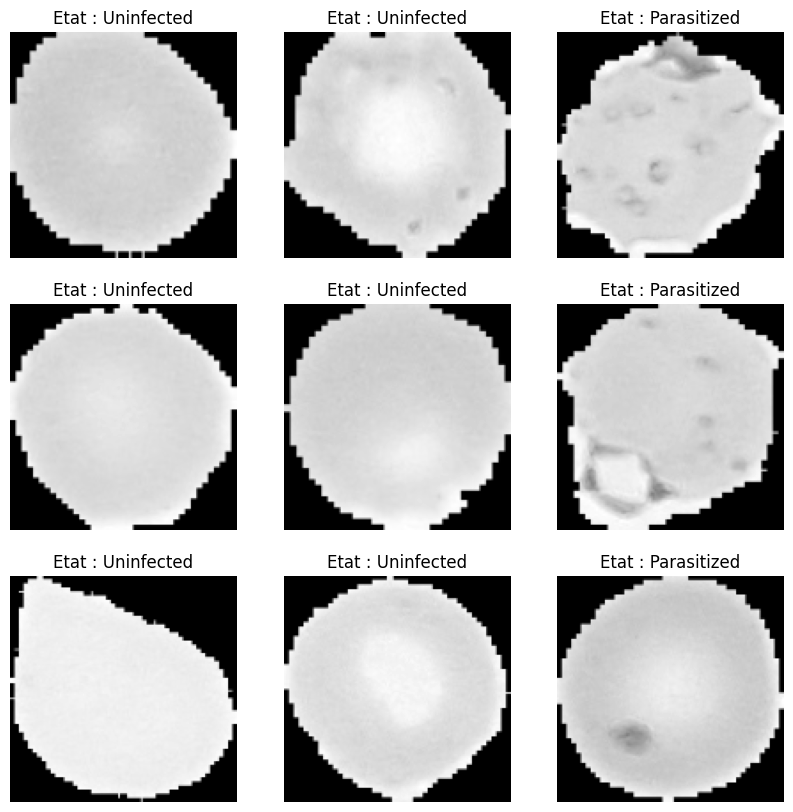

In [187]:
# Afficher quelques exemples d'images et leurs étiquettes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train_grey[i].squeeze(), cmap="gray" if X_train_grey.shape[-1] == 1 else None)
    plt.title(f"Etat : {"Uninfected" if y_train[i] == 1 else "Parasitized"}")
    plt.axis("off")
plt.show()

In [188]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Créer le modèle séquentiel
model = Sequential()


# Couche 1 : Convolution 2D
# - 32 filtres (détecte 32 motifs différents)
# - Taille du noyau : (3, 3)
# - Fonction d'activation : ReLU (rectified linear unit)
# - Input_shape : La taille des images en entrée (hauteur, largeur, canaux)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE_GREY))

# Couche 2 : MaxPooling
# - Réduit la taille de l'image en prenant les valeurs maximales dans une fenêtre (2, 2)
model.add(MaxPooling2D((2, 2)))

# Couche 3 : Convolution 2D
# - 64 filtres pour apprendre des motifs plus complexes
# - Taille du noyau : (3, 3)
# - Fonction d'activation : ReLU
model.add(Conv2D(64, (3, 3), activation='relu'))

# Couche 4 : MaxPooling
# - Une autre couche de pooling pour réduire davantage la taille
model.add(MaxPooling2D((2, 2)))

# Couche 5 : Convolution 2D
# - 128 filtres (détecte des motifs encore plus complexes)
# - Taille du noyau : (3, 3)
# - Fonction d'activation : ReLU
model.add(Conv2D(128, (3, 3), activation='relu'))

# Couche 6 : MaxPooling
# - Réduit encore la taille de l'image
model.add(MaxPooling2D((2, 2)))

# Couche 7 : Flatten
# - Transforme les données 2D en un vecteur 1D pour les couches denses
model.add(Flatten())

# Couche 8 : Dense
# - Couche complètement connectée avec 128 neurones
# - Fonction d'activation : ReLU
model.add(Dense(128, activation='relu'))

# Couche 9 : Dropout
# - Pour éviter le surapprentissage, désactive aléatoirement 50% des neurones
model.add(Dropout(0.5))

# Couche 10 : Dense (Sortie)
# - 1 neurone de sortie pour une classification binaire
# - Fonction d'activation : Sigmoid (produit une probabilité entre 0 et 1)
model.add(Dense(1, activation='sigmoid'))

c:\Users\Patrick\OneDrive\Documents\Etude\Simplon\Brief\21_DeepLearning\paludisme-prediction\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [189]:

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Perte pour une classification binaire
    metrics=['accuracy']        # Suivre la précision pendant l'entraînement
)

In [190]:

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [191]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    # Surveiller la perte de validation
    patience=5,            # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

In [192]:
# Lancer l'entraînement
history = model.fit(
    X_train_grey,              # Ensemble d'entraînement
    y_train,                    # Labels d'entraînement
    epochs=20,                  # Nombre maximum d'époques
    callbacks=[early_stopping],  # Callback pour arrêter tôt
    validation_split=0.1,
    batch_size=32
)

Epoch 1/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 88s 138ms/step - accuracy: 0.5647 - loss: 0.6846 - val_accuracy: 0.6594 - val_loss: 0.6309
Epoch 2/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - accuracy: 0.6721 - loss: 0.6028 - val_accuracy: 0.8871 - val_loss: 0.2818
Epoch 3/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy: 0.9199 - loss: 0.2220 - val_accuracy: 0.9388 - val_loss: 0.1726
Epoch 4/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.9395 - loss: 0.1713 - val_accuracy: 0.9356 - val_loss: 0.1758
Epoch 5/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9465 - loss: 0.1495 - val_accuracy: 0.9483 - val_loss: 0.1634
Epoch 6/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - accuracy: 0.9562 - loss: 0.1226 - val_accuracy: 0.9433 - val_loss: 0.1823
Epoch 7/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - accuracy: 0.9572 - loss: 0.1180 - val_accuracy: 0.9374 - val_loss: 0.1751
Epoch 8/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.9471 - loss: 0

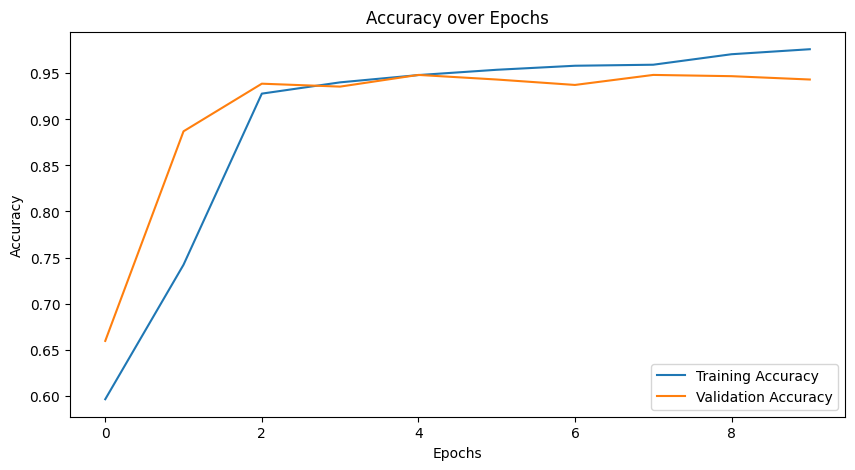

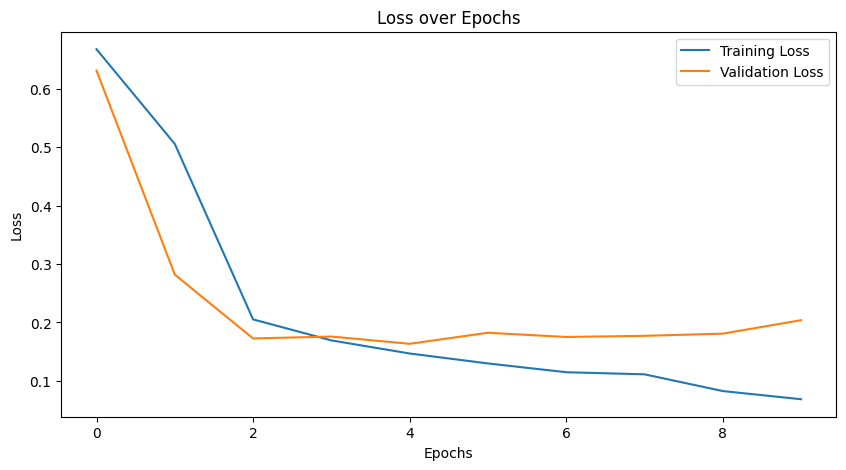

In [193]:
# Importer Matplotlib pour les graphiques
import matplotlib.pyplot as plt

# Courbe de précision
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9420 - loss: 0.1656
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Matrice de confusion avec seuil ajusté :
[[2561  195]
 [ 122 2634]]


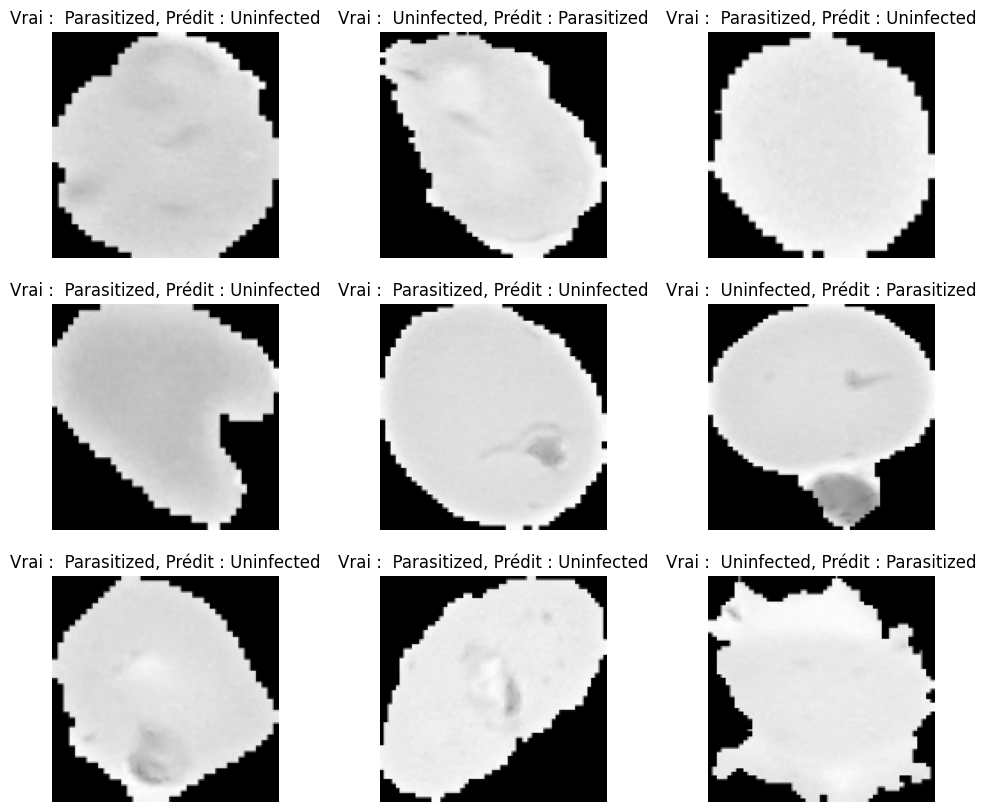

In [195]:
from sklearn.metrics import confusion_matrix, classification_report

#A vous de jouer
# Évaluation de la perte et de la précision
test_loss, test_accuracy= model.evaluate(X_test_grey, y_test)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_grey)

# Réduire le seuil
threshold = 0.3  # Ajuster le seuil selon vos besoins
y_pred_binary = (y_pred > threshold).astype(int).squeeze()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Matrice de confusion avec seuil ajusté :")
print(conf_matrix)

# Visualisation des erreurs de classification
errors = np.where(y_pred_binary != y_test)[0]
plt.figure(figsize=(12, 10))
for i, idx in enumerate(errors[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_grey[idx].squeeze(), cmap="gray")
    plt.title(f"Vrai :  {"Uninfected" if y_test[idx] == 1 else "Parasitized"}, Prédit : {"Uninfected" if y_pred_binary[idx] == 1 else "Parasitized"}")
    plt.axis("off")
plt.show()


1. Observation des erreurs

Faux négatifs (Parasitized prédit comme Uninfected) :
- Problème critique : Les cellules infectées ne sont pas détectées, ce qui peut avoir des implications graves, car elles passeront inaperçues.
- Observation visuelle :
    - Certaines images de cellules parasitées semblent très similaires aux cellules non infectées (peu de caractéristiques visibles).
    - La détection des parasites peut être difficile si les parasites ne sont pas distinctement visibles.

Faux positifs (Uninfected prédit comme Parasitized) :
- Impact moindre : Bien que moins grave, ce type d'erreur entraîne des traitements inutiles ou des fausses alertes.
- Observation visuelle :
    - Dans certaines images, des artefacts ou des variations mineures peuvent être confondus avec des parasites.
    - Les zones floues ou mal définies dans certaines cellules peuvent également induire le modèle en erreur.

c:\Users\Patrick\OneDrive\Documents\Etude\Simplon\Brief\21_DeepLearning\paludisme-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrick\OneDrive\Documents\Etude\Simplon\Brief\21_DeepLearning\paludisme-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrick\OneDrive\Documents\Etude\Simplon\Brief\21_DeepLearning\paludisme-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and b

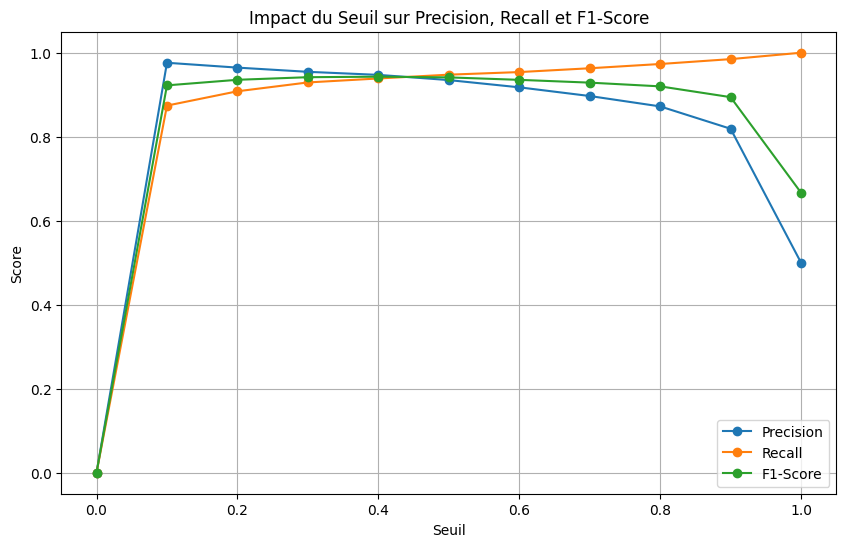

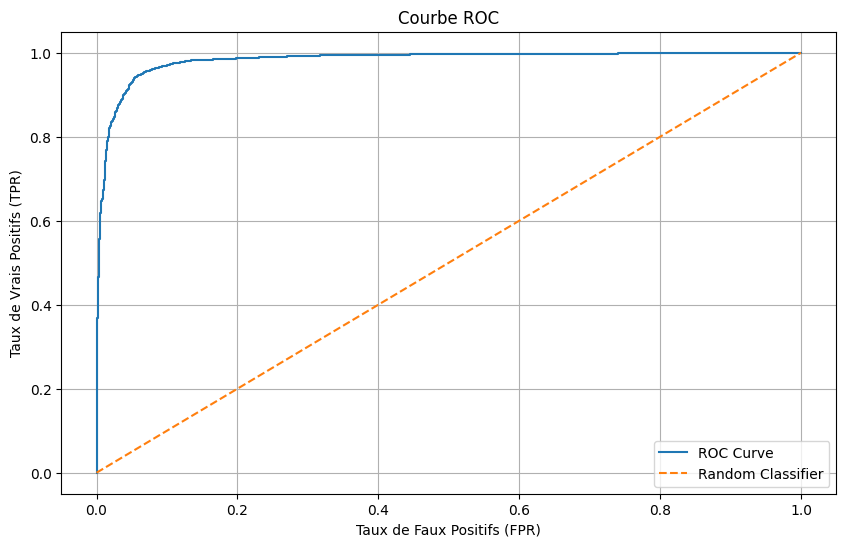

Seuil optimal trouvé à partir de la courbe ROC : 0.41


In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report


# Définir des seuils à tester
thresholds = np.arange(0.0, 1.1, 0.1)

# Initialiser des listes pour stocker les métriques
precision_list = []
recall_list = []
f1_list = []

# Calculer les métriques pour chaque seuil
for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    report = classification_report(y_test, y_pred_binary, target_names=["Parasitized", "Uninfected"], output_dict=True)
    precision_list.append(report["Parasitized"]["precision"])
    recall_list.append(report["Parasitized"]["recall"])
    f1_list.append(report["Parasitized"]["f1-score"])

# Tracer les courbes Precision-Recall et F1-score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision", marker="o")
plt.plot(thresholds, recall_list, label="Recall", marker="o")
plt.plot(thresholds, f1_list, label="F1-Score", marker="o")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Impact du Seuil sur Precision, Recall et F1-Score")
plt.legend()
plt.grid()
plt.show()

# Tracer la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

# Affichage du seuil optimal basé sur la courbe ROC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]
print(f"Seuil optimal trouvé à partir de la courbe ROC : {optimal_threshold:.2f}")

In [197]:
threshold = optimal_threshold

y_pred_binary = (y_pred > threshold).astype(int).squeeze()

Modèle, seuil, et taille d'image enregistrés dans saved_model
Modèle chargé avec succès.
Seuil chargé : 0.41
Taille d'image chargée : (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prédictions sur les échantillons :


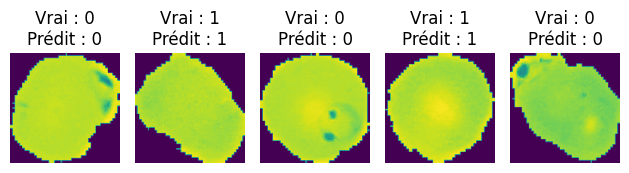

Matrice de confusion :
[[3 0]
 [0 2]]
Rapport de classification :
              precision    recall  f1-score   support

 Parasitized       1.00      1.00      1.00         3
  Uninfected       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [210]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Définir le répertoire d'enregistrement
MODEL_DIR = "saved_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Enregistrer le modèle avec les informations nécessaires
def save_model_with_metadata(model, model_dir, threshold, img_size):
    model.save(os.path.join(model_dir, "malaria_model.h5"))
    with open(os.path.join(model_dir, "metadata.txt"), "w") as f:
        f.write(f"threshold: {threshold}\n")
        f.write(f"img_size: {img_size}\n")
    print(f"Modèle, seuil, et taille d'image enregistrés dans {model_dir}")

# Enregistrer le modèle, le seuil et la taille des images associés
THRESHOLD = 0.41
IMG_SIZE = (128, 128)
save_model_with_metadata(model, MODEL_DIR, THRESHOLD, IMG_SIZE)

# Exemple d'utilisation du modèle enregistré
def load_and_predict_with_preprocessing(model_path, metadata_path, sample_images):
    # Charger le modèle
    loaded_model = tf.keras.models.load_model(model_path)
    print("Modèle chargé avec succès.")

    # Charger le seuil et la taille des images depuis le fichier metadata
    with open(metadata_path, "r") as f:
        metadata = f.readlines()
    threshold = float(metadata[0].split(":")[1].strip())
    img_size = tuple(map(int, metadata[1].split(":")[1].strip().strip("()").split(",")))
    print(f"Seuil chargé : {threshold}")
    print(f"Taille d'image chargée : {img_size}")

    # Redimensionner, normaliser et convertir en niveaux de gris les images
    resized_images = [tf.image.resize(image, img_size).numpy() for image in sample_images]
    resized_images = np.array(resized_images).astype("float32") / 255.0  # Normalisation
    sample_images_grey = resized_images.mean(axis=-1, keepdims=True)  # Conversion en niveaux de gris

    # Prédire sur des échantillons
    predictions = loaded_model.predict(sample_images_grey)
    predictions_binary = (predictions > threshold).astype(int).squeeze()
    return predictions, predictions_binary, sample_images_grey

# Charger des échantillons pour tester
sample_images = X_test[:5]  # Utiliser les 5 premières images de test (non prétraitées)
true_labels = y_test[:5]

# Prédire avec le modèle chargé
model_path = os.path.join(MODEL_DIR, "malaria_model.h5")
metadata_path = os.path.join(MODEL_DIR, "metadata.txt")
y_pred, y_pred_binary, sample_images_grey = load_and_predict_with_preprocessing(model_path, metadata_path, sample_images)

# Afficher les résultats des prédictions
print("Prédictions sur les échantillons :")
for i, (image, true_label, pred_label) in enumerate(zip(sample_images_grey, true_labels, y_pred_binary)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap=None)
    plt.title(f"Vrai : {true_label}\nPrédit : {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(true_labels, y_pred_binary)
print("Matrice de confusion :")
print(conf_matrix)

class_report = classification_report(true_labels, y_pred_binary, target_names=["Parasitized", "Uninfected"])
print("Rapport de classification :")
print(class_report)